In [163]:
import pandas as pd
import gzip
import re
import numpy as np
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import nltk
from sklearn import linear_model
## seaborn for plotting
import seaborn as sns
sns.set(font_scale=1.2, style="white")

# import matplotlib for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style

import warnings
warnings.filterwarnings("ignore")

In [164]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('inaugural')

In [165]:
dataset = []

f = gzip.open("qa_Electronics.json.gz")
for l in f:
    d = eval(l)
    dataset.append(d)

In [166]:
print("There are {} observations of this dataset".format(len(dataset)))

There are 314263 observations of this dataset


In [167]:
# dataset = [d for d in dataset if d['helpful'][1] != 0]

In [168]:
df_raw = pd.DataFrame(data = dataset)
df_raw.head()

,questionType,asin,answerTime,unixTime,question,answerType,answer
0,yes/no,0594033926,"Dec 27, 2013",1.388131e+09,Is this cover the one that fits the old nook c...,Y,Yes this fits both the nook color and the same...
1,yes/no,0594033926,"Jan 5, 2015",1.420445e+09,Does it fit Nook GlowLight?,N,No. The nook color or color tablet
2,open-ended,0594033926,2 days ago,NaN,Would it fit Nook 1st Edition? 4.9in x 7.7in ?,NaN,I don't think so. The nook color is 5 x 8 so n...
3,yes/no,0594033926,17 days ago,NaN,Will this fit a Nook Color that's 5 x 8?,Y,yes
4,yes/no,0594033926,"Feb 10, 2015",1.423555e+09,will this fit the Samsung Galaxy Tab 4 Nook 10.1,N,"No, the tab is smaller than the 'color'"


# data cleaning

In [169]:
df_raw['questionType'].unique()

array(['yes/no', 'open-ended'], dtype=object)

In [170]:
df = df_raw[df_raw['questionType'] == 'yes/no']

In [171]:
df['answerType'].unique()

array(['Y', 'N', '?'], dtype=object)

In [172]:
df[df['answerType'] == '?'].head()

,questionType,asin,answerTime,unixTime,question,answerType,answer
6,yes/no,0594033926,"Jan 30, 2015",1.422605e+09,does this have a flip stand,?,"Hi, no it doesn't"
13,yes/no,0972683275,"Feb 1, 2015",1.422778e+09,my vizio has 200 ht x 600 width mounting holes...,?,I'm sorry mine is mounted already so I could n...
19,yes/no,0972683275,"Dec 9, 2013",1.386576e+09,"Can it be used for VIZIO 39"" CLASS LED SMART T...",?,"We have our 42"" Vizio mounted on it with no pr..."
20,yes/no,1394860919,"Feb 28, 2014",1.393574e+09,"Hi, does it work with MacBook Air 13.3"" latest...",?,"I just got my MacBook Air in January, so I bel..."
21,yes/no,1394860919,"Mar 2, 2014",1.393747e+09,does this cable enable a macbook air 11 inch l...,?,The end that connects to the laptop is a stand...


In [173]:
# remove open
df = df[df['answerType'] != '?'].reset_index(drop=True)

In [174]:
df['answerType'].unique()

array(['Y', 'N'], dtype=object)

In [175]:
df['answerType'].describe()

count     87536
unique        2
top           Y
freq      63726
Name: answerType, dtype: object

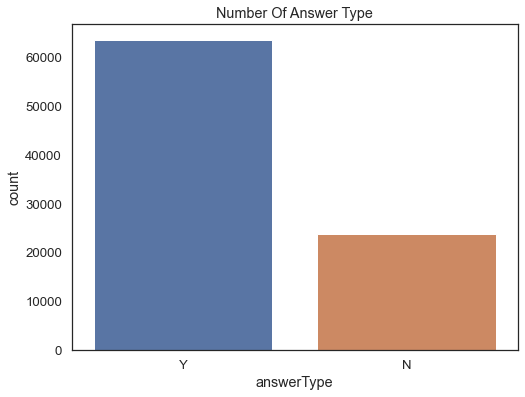

In [176]:
# Distribution of the rating
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.countplot(x=df['answerType'])
plt.title("Number Of Answer Type")
plt.show()

In [431]:
def textCleaning(text_in):
    text_clean = re.sub(r'[^A-Za-z0-9]+',' ', text_in)
    text_clean = text_clean.lower()

    # ps = nltk.PorterStemmer()
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.remove('not')
    text_out = " ".join([w for w in text_clean.split() if w not in stopwords])

    return text_out


In [432]:
df["question_clean"] = df["question"].apply(textCleaning)

In [433]:
df.head()

,questionType,asin,answerTime,unixTime,question,answerType,answer,question_clean
0,yes/no,0594033926,"Dec 27, 2013",1.388131e+09,Is this cover the one that fits the old nook c...,Y,Yes this fits both the nook color and the same...,cover one fits old nook color believe 8x5
1,yes/no,0594033926,"Jan 5, 2015",1.420445e+09,Does it fit Nook GlowLight?,N,No. The nook color or color tablet,fit nook glowlight
2,yes/no,0594033926,17 days ago,NaN,Will this fit a Nook Color that's 5 x 8?,Y,yes,fit nook color 5 x 8
3,yes/no,0594033926,"Feb 10, 2015",1.423555e+09,will this fit the Samsung Galaxy Tab 4 Nook 10.1,N,"No, the tab is smaller than the 'color'",fit samsung galaxy tab 4 nook 10 1
4,yes/no,0594033926,"Jan 30, 2015",1.422605e+09,does it have a flip stand?,N,"No, there is not a flip stand. It has a pocket...",flip stand


In [434]:
df_Y = df[df['answerType'] == 'Y'].reset_index(drop=True)
df_N = df[df['answerType'] == 'N'].reset_index(drop=True)

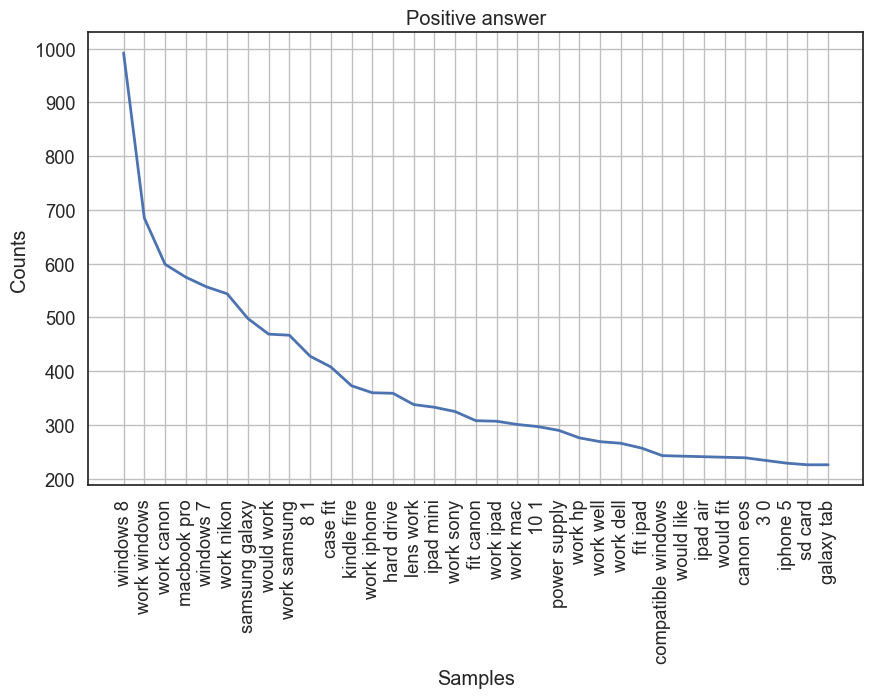

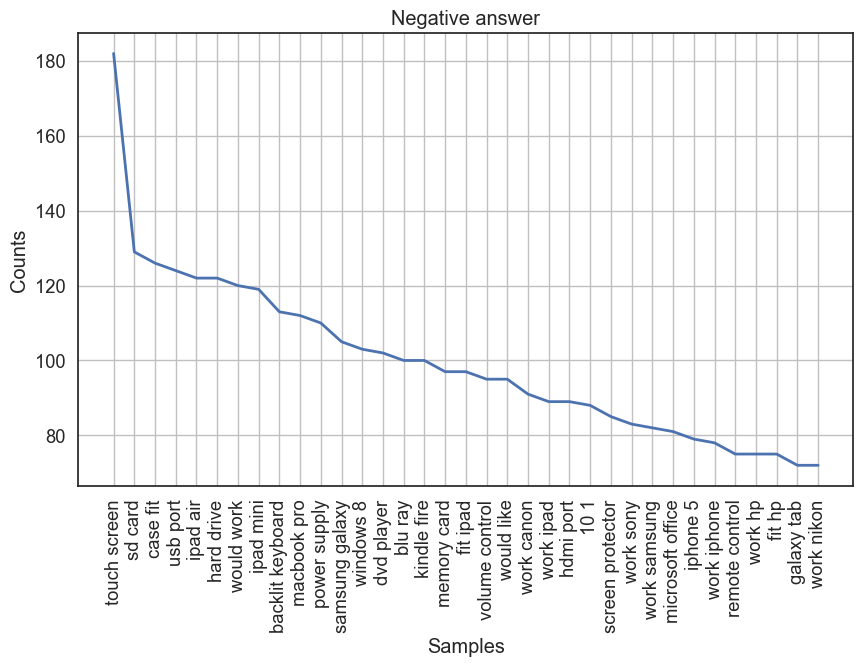

In [435]:
# generate bigram for each type of answer
for df_type in [df_Y, df_N]:
    bigrams = [b for text_list in df_type["question_clean"].values for b in zip(text_list.split()[:-1], text_list.split()[1:])]
    bigrams_text = [b[0]+' '+b[1] for b in bigrams]

    fd = FreqDist(bigrams_text)
    plt.figure(figsize=(10, 6), dpi=100)
 
    plt.title("Positive answer" if df_type["answerType"][0] == 'Y' else "Negative answer")
    fd.plot(35, cumulative=False)
    plt.show()


In [436]:
# ML

In [437]:
### Split dataset

In [438]:
from sklearn.model_selection import train_test_split


In [547]:
# balance
num_pos = sum(df['answerType']=='Y')
num_neg = sum(df['answerType']=='N')
pos_neg_ratio = num_neg / num_pos
df_balanced, _ = train_test_split(df[df['answerType']=='Y'], train_size=pos_neg_ratio)
df_balanced = pd.concat([df_balanced, df[df['answerType']=='N']]).reset_index(drop=True)
X_train, X_test, y_train, y_test = train_test_split(df_balanced['question_clean'], df_balanced['answerType'], random_state=26, train_size = 0.80)

In [489]:
# # without balanced
# X_train, X_test, y_train, y_test = train_test_split(df['question_clean'], df['answerType'], random_state=26, train_size = 0.80)

In [548]:
y_train_float = [1 if y == 'Y' else 0 for y in y_train]
y_test_float = [1 if y == 'Y' else 0 for y in y_test]

In [443]:
######## TFIDF #########################

In [549]:
vectorizer = TfidfVectorizer(sublinear_tf=True,
                        analyzer = "word",
                        ngram_range=(1,2), # unigram and bigram
                        max_features=2000,
                        tokenizer=word_tokenize,
                        stop_words=nltk.corpus.stopwords.words('english'))

In [550]:
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [ ]:
########## SVM ##############

In [541]:
from sklearn.svm import SVC

In [545]:
clf = SVC()
clf.fit(X_train_vectorized, y_train_float)

SVC()

In [546]:
clf.score(X_test_vectorized, y_test_float)

0.6018479630407392

In [449]:
######### Logistic Regression ############

In [553]:
mod_LG = linear_model.LogisticRegression(C=1,max_iter=400, solver='sag')
mod_LG.fit(X_train_vectorized, y_train_float)
print('score on train set {}'.format(mod_LG.score(X_train_vectorized, y_train_float)))
print('score on test set {}'.format(mod_LG.score(X_test_vectorized, y_test_float)))

score on train set 0.6473120537589249
score on test set 0.5906131877362453


In [554]:
mod_LG.predict(X_test_vectorized)

array([1, 1, 0, ..., 1, 1, 1])

In [457]:
######### Random Forest ############

In [458]:
from sklearn.ensemble import RandomForestClassifier

In [459]:
mod_RF = RandomForestClassifier(max_depth=5, random_state=0)
mod_RF.fit(X_train_vectorized, y_train_float)
print("Random Forest score on train set: {}".format(mod_RF.score(X_train_vectorized, y_train_float)))
print("Random Forest score on test set: {}".format(mod_RF.score(X_test_vectorized, y_test_float)))

Random Forest score on train set: 0.5977005459890802
Random Forest score on test set: 0.5844183116337673


In [460]:
mod_RF.score(X_train_vectorized, y_train_float)

0.5977005459890802

In [ ]:
######### BoW

In [566]:
from sklearn.feature_extraction.text import CountVectorizer

In [601]:
bowVectorizer = CountVectorizer(analyzer = 'word',
                            ngram_range=(1,2),
                            max_features = 2000,
                            tokenizer = nltk.word_tokenize,
                            stop_words = nltk.corpus.stopwords.words('english'))

In [578]:
X_train_BoW = bowVectorizer.fit_transform(X_train)
X_test_BoW = bowVectorizer.transform(X_test)

In [579]:
# SHOW THE FEATURE
df_feature_BoW = pd.DataFrame(data = X_train_BoW.todense())
df_feature_BoW.columns = bowVectorizer.get_feature_names()


In [604]:
mod_LG_BoW = linear_model.LogisticRegression(C=0.01,max_iter=400, solver='sag')
mod_LG_BoW.fit(X_train_BoW, y_train_float)
print('score on train set {}'.format(mod_LG_BoW.score(X_train_BoW, y_train_float)))
print('score on test set {}'.format(mod_LG_BoW.score(X_test_BoW, y_test_float)))

score on train set 0.6188576228475431
score on test set 0.5906131877362453
